#Librerías

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

#Cargar la información

In [45]:
df = pd.read_csv('Habitat-E.csv', index_col = 'Date', parse_dates = True)
df = df.asfreq('d') #Establece la frecuencia de la serie en diaria


In [46]:
df.isnull().sum()     #Verifica si existen valores nulos

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [47]:
del df['Open']
del df['High']
del df['Low']
del df['Volume']

#Separar los datos en un conjunto de entrenamiento y prueba

In [48]:
size = int(len(df)*0.8)
df_train, df_test = df[:size], df[size:]

## Se debe corroborar que no se repita la fecha entre el conjunto de entrenamiento y prueba

In [49]:
df_train.tail()

,Close
Date,
2019-11-21,41585
2019-11-22,41629
2019-11-23,41629
2019-11-24,41629
2019-11-25,41718


In [50]:
df_test.head()

,Close
Date,
2019-11-26,41863
2019-11-27,41976
2019-11-28,41985
2019-11-29,41915
2019-11-30,41915


#Analizar tendencia, estacionalidad y residuos de la serie

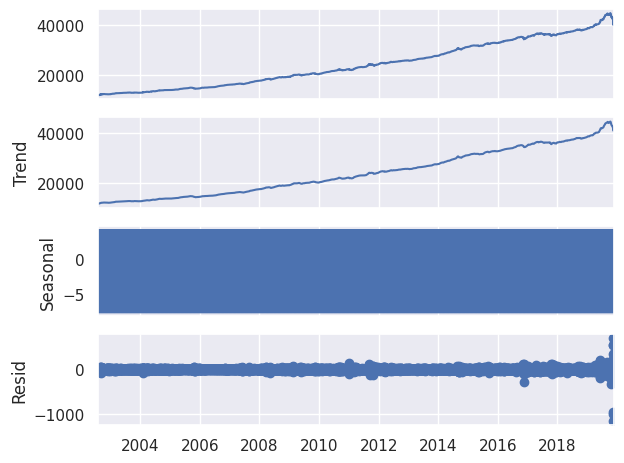

In [51]:
s_dec_additive = seasonal_decompose(df_train, model = 'additive')
s_dec_additive.plot()
plt.show()

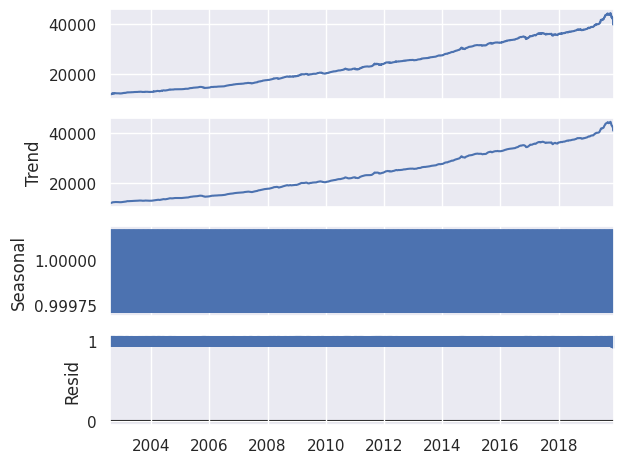

In [52]:
s_dec_multiplicative = seasonal_decompose(df_train, model = 'multiplicative')    #En ambos casos no se evidencia una estacionalidad, pero si una tendencia positiva
s_dec_multiplicative.plot()
plt.show()

#Análisis de estacionaridad

In [55]:
sts.adfuller(df_train.Close)     #Se obtuvo un valor P de 99% por lo que con una significancia de 5% existe evidencia de que no es una serie estacionaria

(1.4608997808718673,
 0.9973739770800493,
 32,
 6293,
 {'1%': -3.4313895629133992,
  '5%': -2.8619993951727514,
  '10%': -2.567014533031778},
 63407.25471217314)

#Probar modelos que realicen la mejor predicción de la serie

##Se define una función de log verosimilitud que pueda comparar qué modelo es mejor

In [56]:
def LLR_test(mod_1, mod_2, DF = 1):             #DF son los grados de libertad y se calculan con la diferencia en la cantidad de parametros que se necesita entre ambas predicciones
  L1 = mod_1.llf                                #llf es para calcular log verosimilitud de cada predicción
  L2 = mod_2.llf
  LR = (2*(L2 - L1))
  p = chi2.sf(LR,DF).round(3)
  return p

##Modelos autoregresivos

###Crear los retornos

In [57]:
df_train['returns'] = df_train.Close.pct_change(1).mul(100)

<ipython-input-57-70c3f036e9fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['returns'] = df_train.Close.pct_change(1).mul(100)


In [58]:
df_train.head()

,Close,returns
Date,,
2002-08-01,11778,NaN
2002-08-02,11775,-0.025471
2002-08-03,11775,0.000000
2002-08-04,11775,0.000000
2002-08-05,11796,0.178344


In [62]:
sts.adfuller(df_train.returns[1:]) #Ahora si los retornos cumplen con la condición de ser estacionarios

(-11.891480431149372,
 5.854625974100925e-22,
 31,
 6293,
 {'1%': -3.4313895629133992,
  '5%': -2.8619993951727514,
  '10%': -2.567014533031778},
 -8415.189907521572)

###Módelo autoregresivo de orden 1

In [65]:
model_ar_1 = ARIMA(df_train.returns[1:], order = (1,0,0))
results_ar_1 = model_ar_1.fit()
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(1, 0, 0)   Log Likelihood                4000.832
Date:                Fri, 26 Apr 2024   AIC                          -7995.664
Time:                        02:17:00   BIC                          -7975.407
Sample:                    08-02-2002   HQIC                         -7988.648
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.009      0.000       0.016       0.024
ar.L1          0.1726      0.003     50.292      0.000       0.166       0.179
sigma2         0.0165   3.55e-05    465.027      0.000       0.016       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):          12876049.69
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       224.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###Modelo autoregresivo de orden 2

In [66]:
model_ar_2 = ARIMA(df_train.returns[1:], order = (2,0,0))
results_ar_2 = model_ar_2.fit()
print(results_ar_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_1,results_ar_2))) #Compara el modelo Autoregresivo de orden 1 con el de orden 2

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(2, 0, 0)   Log Likelihood                4004.473
Date:                Fri, 26 Apr 2024   AIC                          -8000.947
Time:                        02:21:05   BIC                          -7973.938
Sample:                    08-02-2002   HQIC                         -7991.592
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.655      0.000       0.016       0.025
ar.L1          0.1667      0.005     30.358      0.000       0.156       0.177
ar.L2          0.0339      0.008      4.400      0.0

###Modelo autoregresivo de orden 3

In [67]:
model_ar_3 = ARIMA(df_train.returns[1:], order = (3,0,0))
results_ar_3 = model_ar_3.fit()
print(results_ar_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_2,results_ar_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(3, 0, 0)   Log Likelihood                4057.316
Date:                Fri, 26 Apr 2024   AIC                          -8104.633
Time:                        02:22:08   BIC                          -8070.871
Sample:                    08-02-2002   HQIC                         -8092.940
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.802      0.000       0.016       0.024
ar.L1          0.1711      0.006     28.500      0.000       0.159       0.183
ar.L2          0.0554      0.008      6.974      0.0

###Modelo autoregresivo de orden 4

In [68]:
model_ar_4 = ARIMA(df_train.returns[1:], order = (4,0,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_3,results_ar_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(4, 0, 0)   Log Likelihood                4060.680
Date:                Fri, 26 Apr 2024   AIC                          -8109.360
Time:                        02:23:05   BIC                          -8068.846
Sample:                    08-02-2002   HQIC                         -8095.328
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002     10.122      0.000       0.016       0.024
ar.L1          0.1669      0.006     28.472      0.000       0.155       0.178
ar.L2          0.0572      0.008      7.107      0.0

###Modelo autoregresivo de orden 5

In [69]:
model_ar_5 = ARIMA(df_train.returns[1:], order = (5,0,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_4,results_ar_5)))      #Hasta aquí llega

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(5, 0, 0)   Log Likelihood                4061.294
Date:                Fri, 26 Apr 2024   AIC                          -8108.589
Time:                        02:23:54   BIC                          -8061.323
Sample:                    08-02-2002   HQIC                         -8092.218
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002     10.243      0.000       0.016       0.024
ar.L1          0.1664      0.006     28.626      0.000       0.155       0.178
ar.L2          0.0555      0.008      7.083      0.0